# Exercício: LoRA

> - Exercício didático para entender a técnica de fazer ajuste fino em modelos grandes usando poucos recursos
> - Aplicar no pré exercício de análise de sentimento ou no segundo exercício, e modelo de linguagem, com vocabulário de 3000 palavras, embedding size e 2 camadas, treinados da forma usual (medir tempo de treinamento/época)
> - Modificar o seu modelo para adotar a técnica do LoRA no embedding e nas 2 camadas, e fazer o ajuste-fino, isto é, continuar o treinamento anterior, lembrando que as matrizes originais ficarão congeladas e o ajuste dos pesos serão apenas aplicados nas matrizes do LoRA. Medir o tempo de treinamento/época.
> - Por último, substituir o modelo original, com os novos pesos calculados pelo W + LoRA.
> 
> O que é esperado de aprendizado com LoRA:
> 
> - Modificar o modelo para incluir a soma das duas matrizes do LoRA
> - Congelar parte do modelo para poder avançar no treino com a mesma tarefa, porém utilizando apenas as matrizes do LoRA, com bem menos pesos e consequentemente mais rápido
> - Atualizar o modelo original com o resultado do treino continuado pelo LoRA
> 
> O enunciado é flexível e os objetivos estão acima. A implementação pode ser feita na mesma classe, com um parâmetro que indica se vai usar ou não as matrizes LoRA.

Iremos começar importando os módulos que serão utilizados na atividade:

In [6]:
import string # Manipular strings
from collections import Counter # Fazer contagem de elementos
import random # Operações randômicas
import os # Manipular arquivos
import time # Medição de tempo
import abc # Classes abstratas
import itertools # Iterators
from typing import List, Dict, Union, Tuple, Optional # Type hints

import numpy as np # Operações vetoriais
from numpy.testing import assert_raises, assert_array_equal, assert_array_almost_equal # Testes
from numpy.typing import ArrayLike # Type hints
import tqdm # Print do progresso
import torch # ML
from torch.utils.data import Dataset, DataLoader # Preparação de dados
import matplotlib.pyplot as plt # Plots
import wandb # Logging

E algumas funções auxiliares que serão utilizadas:

In [7]:
def assert_array_not_equal(array1:ArrayLike, array2:ArrayLike) -> None:
    """
    Raises an AssertionError if two array_like objects are equal.

    Args:
        array1 (ArrayLike): First array to check.
        array2 (ArrayLike): Second array to check.
    """
    assert_raises(AssertionError, assert_array_equal, array1, array2)

In [8]:
def reset_seeds(seed:int=18) -> None:
    """
    Resets the random generators from random and torch to a fixed seed.
    """
    random.seed(seed)
    torch.manual_seed(seed)

## Preparação dos dados.

Nesta seção serão definidas funções para preparar os dados para treino do modelo. Devido a necessidade de alterar os parâmetros constantemente durante os experimentos de treino, são definidas em funções as operações que são necessárias. Exemplos são executados para mostrar o funcionamento correto das operações.

### Faz download e carrega o dataset

Nesta seção os dados serão transferidos, lidos e limpos.

O primeiro passo é realizar o download dos dados:

In [9]:
if not os.path.isfile("67724.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67724.txt.utf-8

if not os.path.isfile("67725.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67725.txt.utf-8

Seguido pela leitura:

In [10]:
text = open("67724.txt.utf-8","r", encoding="utf8").read()
text += open("67725.txt.utf-8","r", encoding="utf8").read()

paragraphs = text.split("\n\n")
len(paragraphs)

4971

E limpeza dos dados.

São realizadas as seguintes operações seguindo o paper "A Neural Probabilistic Language Model" (Bengio, 2003).


- Pontuação: é mantida, porém separada do texto para permitir criação de símbolos próprios no vocabulário, e evitar a criação de várias símbolos representando as palavras com pontuação ("pontuação" -> "pontuação" + "," )
- Número: convertidos para símbolo especial. No caso todos os números são convertidos para "999", para que convirjam para o mesmo símbolo no vocabulário
- Letras maiúsculas: convertidas para minúsculas.
- Nomes próprios: não são alterados devido a necessidade de serem identificados, diferente do paper.
- Palavras raras: são removidas ao criar o vocabulário.

In [11]:
def clean_text(text:str) -> str:
    '''
    Clean the text, changing upper case and setting numbers to 999.
    '''
    
    text = text.lower() # Upper Case -> lower case
    
    old_text = text.split()
    new_text = []

    for j in range(len(old_text)):
        word = old_text[j] 

        if word.isdigit(): #Number -> 999
            word = "999"
        elif len(word) > 1 and word[0] in string.punctuation: # Ponctuation -> separate
            old_text.insert(j+1, word[1:])
            word = word[0]
        elif word[-1] in string.punctuation and len(word) > 1: # Ponctuation -> separate
            old_text.insert(j+1, word[:-1])
            old_text.insert(j+2, word[-1])
            
            word = ""
        
        if len(word) > 0: # No empty words
            new_text.append(word)
    
    return " ".join(new_text)

In [12]:
cleaned_paragraphs = [paragraph.replace("\n", " ") for paragraph in paragraphs if paragraph.strip()] # Removes \n

for i in range(len(cleaned_paragraphs)):
    cleaned_paragraphs[i] = clean_text(cleaned_paragraphs[i])


Podemos ver um exemplo de parágrafo limpo do dataset, junto com a quantidade total de parágrafos obtidos:

In [13]:
print("SAMPLE ----------------")
print(cleaned_paragraphs[0])
print("---------------------")

print(len(cleaned_paragraphs))

SAMPLE ----------------
﻿the project gutenberg ebook of o guarany : romance brazileiro , vol . 999 ( of 999 ) this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it , give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org . if you are not located in the united states , you
---------------------
4892


### Análise do dataset

In [14]:
def count_words(texts:List[str]) -> Counter:
    """
    Counts the words in the texts.

    Args:
        texts (List[str]): List of strings with the texts.

    Returns:
        Counter: counter with the word count across all texts.
    """
    
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split(" "))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

len(word_counts)

11470

### Criando um vocabulário

Com a contagem de palavras podemos definir uma função para criar um novo vocabulário:

In [15]:
def create_vocab(word_counts:Counter, vocab_size:int) -> Tuple[Dict[str, int], List[str]]:
    """
    Generates the vocabulary with the most frequent words.

    Args:
        word_counts (Counter): word count to generate vocabulary.
        vocab_size (int): maximum size for the vocabulary.

    Returns:
        Dict[str, int]: vocabulary mapping words to codes.
        List[str]: inverse vocabulary mapping codes to words.
    """


    most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
    vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}

    inverse_vocab = list(vocab.keys())

    return vocab, inverse_vocab

E podemos executar um teste mostrando a geração de um vocabulário e suas primeiras 0 entradas:

In [16]:
test_vocab_size = 1000
test_vocab, test_inverse_vocab = create_vocab(word_counts, test_vocab_size)

In [17]:
list(itertools.islice(test_vocab.items(), 10))

[(',', 1),
 ('a', 2),
 ('que', 3),
 ('-', 4),
 ('o', 5),
 ('de', 6),
 ('e', 7),
 (';', 8),
 ('.', 9),
 ('um', 10)]

É interessante observar que as palavras mais frequentes são acentuações, o que pode dificultar o aprendizado de sentenças significativas.

### Codificando e Decodificando sentenças

Podemos utilizar as seguintes funções para codificar um texto e decodificá-lo:

In [18]:
def encode_sentence(sentence:Union[str,List[str]], vocab:Dict) -> List[int]:
    """
    Encodes a sentence using a vocabulary.

    Args:
        sentence (Union[str,List[str]]): sentence to encode. Or a string,
            or the string already separated into words
        vocab (Dict): vocabulary to encode. Maps words to codes.

    Returns:
        List[int]: the encoded sentence
    """
    if isinstance(sentence, list):
        words = sentence
    else:
        words = sentence.split(" ")
    
    return [vocab.get(word, 0) for word in words]

In [19]:
def decode_sentence(encoding:List[int], inverse_vocab:List[str]) -> List[str]:
    """
    Decodes a sentence back to words.

    Args:
        encoding (List[int]): encoded sentence to decode.
        inverse_vocab (List[str]): inverse vocabulary. Maps codes to words

    Returns:
        List[str]: decoded sentence. Unknown codes are decoded to '???' 
    """
    result = []

    for encoding_i in encoding:
        if encoding_i == 0:
            result.append("???")
        else:
            result.append(inverse_vocab[encoding_i-1])

    return result

### Separação e Classe do dataset

Aqui iremos definir as sentenças a partir dos textos; divídi-las em treino, teste e valiadação; e criar a classe para carregar os dados durante os experimentos.

In [20]:
def create_sequences(texts:List[str], context_size:int, 
                     vocab:Dict) -> Tuple[List[List[int]], List[int]]:
    """
    Creates sequences from the texts, with the target (word to predict), 
    using a fixed size and vocabulary.

    Args:
        texts (List[str]): texts to create sequences.
        context_size (int): size of the sequences.
        vocab (Dict): maps words to codes.

    Returns:
        List[List[int]]: created sequences. 
        List[int]]: created targets.
    """


    x_all = []
    y_all = []

    for paragraph in texts:
        start = 0
        end = context_size

        paragraph = encode_sentence(paragraph, vocab)

        while end < len(paragraph):
            x = paragraph[start:end]
            y = paragraph[end]

            if not ( 0 in x or 0 == y):
                x_all.append(x)
                y_all.append(y)

            start += 1
            end += 1
            
    x_all = np.array(x_all)
    y_all = np.array(y_all)

    return x_all, y_all

Criamos um dataset de teste e validamos que as entradas e targets possuem o mesmo tamanho.

In [21]:
test_context_size = 10

test_x_all, test_y_all = create_sequences(cleaned_paragraphs, test_context_size, test_vocab)

In [22]:
assert len(test_x_all) == len(test_y_all)

Para evitar viéses, definimos uma função para embaralhar o dataset:

In [23]:
def shuffle_dataset(x:List, y:List) -> Tuple[List, List]:
    """
    Shuffle the dataset.

    Args:
        x (List): dataset inputs.
        y (List): dataset targets.

    Returns:
        List: shuffled inputs. 
        List: shuffled outputs.
    """

    indexes = list(range(len(x)))
    random.shuffle(indexes)

    x = x[indexes]
    y = y[indexes]

    return x, y

E separamos os dados em treino (60%), validação (20%) e teste (20%):

In [24]:
def separate_dataset(x_all:List, y_all:List) -> Tuple[Tuple[List, List], Tuple[List, List], Tuple[List, List]]:
    """
    Separate the data in train, validation and test.

    Args:
        x_all (List): all dataset inputs.
        y_all (List): all dataset targets.

    Returns:
        Tuple[List, List]: train inputs and targets. 
        Tuple[List, List]: validation inputs and targets.
        Tuple[List, List]: test inputs and targets.
    """
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]
    y_train = y_all[0:cut1]

    x_val = x_all[cut1:cut2]
    y_val = y_all[cut1:cut2]

    x_test = x_all[cut2:]
    y_test = y_all[cut2:]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

Separamos os conjuntos e demonstramos que a separação separa corretamente os dados:

In [25]:
(test_x_train, test_y_train), (test_x_val, test_y_val), (test_x_test, test_y_test) = separate_dataset(test_x_all, test_y_all)

In [26]:
assert len(test_x_train)+len(test_x_val)+len(test_x_test) == len(test_x_all)

assert len(test_x_train) == int(0.6*len(test_x_all))
assert len(test_x_val) == np.floor(0.2*len(test_x_all))
assert len(test_x_test) == np.ceil(0.2*len(test_x_all))

assert len(test_x_train) == len(test_y_train)
assert len(test_x_val) == len(test_y_val)
assert len(test_x_test) == len(test_y_test)

Criamos a classe para manipular o dataset:

In [27]:
class TextPredictDataset(Dataset):
    """
    Text prediction dataset.

    Input: sequence of encoded words.
    Target: next word for the sequence.
    """
    
    def __init__(self, x_data:List[List[int]], y_data:List[int]) -> None:
        """
        Creates a new dataset.

        Args:
            x_data (List[List[int]]): dataset inputs.
            y_data (List[int]): dataset targets.

        Raises:
            ValueError: if input and target have different sizes.
        """

        self._x_data = torch.tensor(x_data)-1
        self._y_data = torch.tensor(y_data, dtype=torch.int64)-1
        
        if len(x_data) != len(y_data):
            raise ValueError(f"x_data and y_data must have same size. ({len(x_data)} ≠ {len(y_data)})")
        
        self._size = len(x_data)

    def __len__(self) -> int:
        """
        Gets the size of the dataset.

        Returns:
            int: dataset size.
        """

        return self._size

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Gets a item of the dataset.

        Args:
            idx (int): data index.

        Returns:
            torch.Tensor: dataset input. 
            torch.Tensor: dataset target.
        """
        return self._x_data[idx], self._y_data[idx]


Geramos um dataset de exemplo e mostramos que os tamanhos das entradas e saídas está correto:

In [28]:
test_train_dataset = TextPredictDataset(test_x_train, test_y_train)

assert_array_equal(test_train_dataset[0][0].shape, [test_context_size])
assert_array_equal(test_train_dataset[0][1].shape, [])

Por fim, mostramos o uso de um DataLoader e mostramos que os dados possuem tamanhos corretos:

In [29]:
test_batch_size = 5
test_train_loader = DataLoader(test_train_dataset, batch_size=test_batch_size, shuffle=True)

test_data = next(iter(test_train_loader))

assert_array_equal(test_data[0].shape, [test_batch_size, test_context_size])
assert_array_equal(test_data[1].shape, [test_batch_size])

### Juntando tudo

Para o uso posterior, podemos juntar todas as funções criadas realizando o processo completo de geração do dataset:

In [30]:
def create_data_loaders(texts:List[str], vocab_size:int, context_size:int, batch_size:int) -> Tuple[Dict, List, Dict[str, DataLoader]]:
    """
    Generates a text prediction dataset.

    Args:
        texts (List[str]): texts to generate the dataset.
        vocab_size (int): size of the vocabulary (know words).
        context_size (int): size of the sequences.
        batch_size (int): size of the batchs.

    Returns:
        Dict: vocabulary. Maps words to codes.
        List: inverse vocabulary. Maps codes to words.
        Dict[str, DataLoader]: dataloaders.
    """

    word_counts = count_words(texts)
    vocab, inverse_vocab = create_vocab(word_counts, vocab_size)

    x_all, y_all = create_sequences(texts, context_size, vocab)
    
    x_all, y_all = shuffle_dataset(x_all, y_all)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = separate_dataset(x_all, y_all)

    train_dataset = TextPredictDataset(x_train, y_train)
    val_dataset = TextPredictDataset(x_val, y_val)
    test_dataset = TextPredictDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    dataloaders = {"train": train_loader, "val":val_loader, "test":test_loader}

    return vocab, inverse_vocab, dataloaders

## Modelo

Esta seção irá implementar o base modelo que será treinado, baseado em "A Neural Probabilistic Language Model" (Bengio, 2003).

### Embedding

Para o embedding utilizamos uma matriz de look-up aprendível:

In [31]:
class Embedding(torch.nn.Module):
    """
    Converts codes to embeddings.
    """

    def __init__(self, embed_dim:int, vocab_size:int) -> None:
        """
        Creates a new Embedding layer.

        Args:
            embed_dim (int): size of the embedding in the output.
            vocab_size (int): size of the vocabulary the words were coded.
        """

        super().__init__()

        C = torch.Tensor(vocab_size, embed_dim)
        torch.nn.init.xavier_uniform_(C)
        self.C = torch.nn.Parameter(C)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        """
        Embeds the input sequences.

        Args:
            input_tensor (torch.Tensor): sequences to be embeded.

        Returns:
            torch.Tensor: result embeddings.
        """
        
        #OBS: I checked, "index_select" doesn't work with batchs, "index" (third parameter) must be 1-D
        result = torch.stack([torch.index_select(self.C, 0, input_i) for input_i in input_tensor])
        
        return result

E testamos se a camada gera o embedding corretamente:

In [32]:
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size

test_data = torch.empty((2, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_vocab_size)

embedding = Embedding(test_embed_dim, test_vocab_size)

result = embedding(test_data)
result = result.detach()

C = embedding.C.detach()

assert_array_equal(C.shape, [test_vocab_size, test_embed_dim]) #C matrix have correct shape
assert_array_equal(result.shape, [2, test_sequence_size, test_embed_dim])
assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_equal(result[0, 0], C[0]) #First result = embedding of first word

### Modelo

In [33]:

class LanguageModel(torch.nn.Module):

    def __init__(self, context_size:int, vocab_size:int, embed_dim:int, hidden_units:int):
        super().__init__()
        
        #V = |Vocab|, m = |Embed|
        #n-1 = c = |Context|
        #h = |Hidden|
        
        #C[V, m](input) -> x[c*m]
        #Linear1(x) -> x2[h]
        #ReLU(x2) -> x3[h]  | alterado do paper (tanh)
        #Linear2(x) -> x4[V]
        #Linear3(x3) -> x5[V] | sem bias (Linear2 já tem bias)
        #Add(x4, x5) -> output
        #Sem softmax -> melhor estabilidade

        m = int(context_size*embed_dim)

        self.embedding = Embedding(embed_dim, vocab_size)
        self.linear1 = torch.nn.Linear(m, hidden_units)
        self.relu = torch.nn.ReLU() 
        self.linear2 = torch.nn.Linear(m, vocab_size)
        self.linear3 = torch.nn.Linear(hidden_units, vocab_size, bias=False)

    def forward(self, x:torch.Tensor) -> torch.Tensor:

        x = self.embedding(x)
        x = x.flatten(start_dim=1)
        
        x2 = self.linear1(x)
        x3 = self.relu(x2)
        x4 = self.linear2(x)
        x5 = self.linear3(x3)

        output = x4+x5

        return output

#### Teste do Modelo

Testamos o modelo com uma entrada aleatória para verificar se as saídas possuem tamanhos corretos:

In [34]:
test_batch_size = 5
test_embed_dim = 2
test_vocab_size = 3
test_hidden_units = 3
test_sequence_size = test_vocab_size

test_model = LanguageModel(test_sequence_size, test_vocab_size, test_embed_dim, test_hidden_units)

In [35]:
test_data = torch.empty((test_batch_size, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_sequence_size)

inputs = test_data
targets = test_vocab_size*torch.rand(test_batch_size).long()

output = test_model(inputs)
result = output.argmax(dim=1)

assert_array_equal(output.shape, [test_batch_size, test_vocab_size])
assert_array_equal(result.shape, targets.shape)

## Pré-treino

Nesta seção iremos realizar o treino inicial, iniciando pela definição de algumas funções auxiliares.

### Funções auxiliares

Iremos definir quatro funções auxiliares para: calcular a perplexidade a partir da loss, printar informações, calcular a loss e realizar o treinamento:

In [36]:
def ppl(loss:torch.Tensor) -> torch.Tensor:
    """
    Computes the perplexity from the loss.

    Args:
        loss (torch.Tensor): loss to compute the perplexity.

    Returns:
        torch.Tensor: corresponding perplexity.
    """
    return torch.exp(loss)

In [37]:
def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, 
               time:float=0.0, accuracy:Optional[float]=None):
    """
    Prints the information of a epoch.

    Args:
        loss_value (torch.Tensor): epoch loss.
        epoch (int): epoch number.
        total_epochs (int): total number of epochs. 
        time (float, optional): time to run the epoch. Don't print if is 0.0. Defaults to 0.0.
        accuracy (float, optional): epoch accuracy.
    """
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if accuracy is not None:
        print(f', Accuracy: {100*accuracy:.4f}%')

    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")

In [38]:
MODE_TRAIN = 0
MODE_EVALUATE = 1

In [47]:
def compute_loss(model:torch.nn.Module, loader:DataLoader, 
                 criterion:torch.nn.Module, mode:int = MODE_EVALUATE, 
                 optimizer:Optional[torch.optim.Optimizer]=None, 
                 accumulation_steps:Optional[int] = 1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the loss from a model across a dataset.

    If in train mode also runs optimizer steps.

    Args:
        model (torch.nn.Module): model to evaluate.
        loader (DataLoader): dataset.
        criterion (torch.nn.Module): loss function to compute.
        mode (int): mode of the computation. 
                    If MODE_EVALUATE, computes without gradient, in eval mode and detachs loss.
                    If MODE_TRAIN, computes with gradient and in train mode.
                    Default is MODE_EVALUATE.
        optimizer (torch.optim.Optimizer, optional): optimizer to use in the train mode.

    Returns:
        torch.Tensor: resulting loss.
    """
    device = next(iter(model.parameters())).device

    if mode == MODE_EVALUATE:
        model.eval()
        torch.set_grad_enabled(False)
    elif mode == MODE_TRAIN:
        model.train()
        torch.set_grad_enabled(True)
        optimizer.zero_grad()
    else:
        raise ValueError(f"Unknown mode: {mode}.")

    batch_index = 0
    total_loss = torch.tensor(0, dtype=torch.float32, device=device)
    n = 0
    for inputs, targets in tqdm.tqdm(loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        logits = model(inputs)
        logits = logits.view(-1, logits.shape[-1])

        loss : torch.Tensor = criterion(logits.squeeze(), targets)
        total_loss += loss*targets.size(0)
        
        
        n += targets.size(0)

        if mode == MODE_TRAIN:
            loss /= accumulation_steps
            loss.backward()

            if ((batch_index+1) % accumulation_steps == 0) or (batch_index+1 == len(loader)):
                optimizer.step()
                optimizer.zero_grad()

        batch_index += 1

    total_loss /= n 
    
    torch.set_grad_enabled(True)

    total_loss = total_loss.detach()

    return total_loss


In [64]:
def train(model:torch.nn.Module, criterion:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          dataloaders:DataLoader, n_epoch:int, accumulation_steps:int=1, 
          use_wandb:bool=False) -> Dict[str, ArrayLike]:
    hist = {}
    hist["loss_train"] = []
    hist["loss_val"] = []
    hist["ppl_train"] = []
    hist["ppl_val"] = []

    loss_val = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
        
    print("VAL ", end="")
    print_info(loss_val, -1, n_epoch)

    for epoch in range(n_epoch):
        start_time = time.time() 

        loss_train = compute_loss(model, dataloaders["train"], criterion, MODE_TRAIN, optimizer, accumulation_steps)

        end_time = time.time() 
        
        epoch_duration = end_time - start_time 

        ppl_train = ppl(loss_train)

        print_info(loss_train, epoch, n_epoch, epoch_duration)
        
        #Validation stats
        loss_val = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
        ppl_val = ppl(loss_val)
        
        print("VAL ", end="")
        print_info(loss_val, epoch, n_epoch)

        #Save history
        hist["loss_train"].append(loss_train.item())
        hist["loss_val"].append(loss_val.item())
        hist["ppl_train"].append(ppl_train.item())
        hist["ppl_val"].append(ppl_val.item())


        log = {
            "loss_train": loss_train.item(),
            "loss_val": loss_val.item(),
            "ppl_train": ppl_train.item(),
            "ppl_val": ppl_val.item(),
        }

        if use_wandb:
            wandb.log(log)

    for key in hist:
        hist[key] = np.array(hist[key])

    if use_wandb:
        wandb.finish()

    return hist

### Inicialização

Começamos o processo de treino inicializando as variáveis.

Definimos se será realizado o logging utilizando o wandb:

In [65]:
use_wandb = False

Checamos se existe uma GPU disponível:

In [66]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Definimos os parâmetros de treino:

Definimos os parâmetros de treino. No caso os parâmetros a seguir são do melhor treino, enquanto que todas as variações testadas podem ser encontradas em [https://api.wandb.ai/links/eltoncn/2exfkyeh](https://api.wandb.ai/links/eltoncn/2exfkyeh).

In [67]:
accumulation_steps = 1 # Passos de acumulação de gradiente
batch_size = 32 # Tamanho de um batch
context_size = 5 # Tamanho de uma sequência
embed_dim = 64 # Tamanho do feature vector de cada palavra
hidden_units = 300 # Quantidade de unidades na camada escondida
lr = 5e-1 # Taxa de treinamento
n_epoch = 10 # Quantidade de epochs
optimizer_class = torch.optim.SGD # Otimizador
vocab_size = 3000 # Quantidade de palavras no vocabulário
weight_decay = 1e-3 # Regularização L2

config = {
    "accumulation_steps": accumulation_steps,
    "batch_size": batch_size,
    "embed_dim":embed_dim,
    "hidden_units":hidden_units,
    "lr": lr,
    "n_epoch": n_epoch,
    "optimizer_class": optimizer_class.__name__,
    "context_size" : context_size,
    "weight_decay": weight_decay,
}

if use_wandb:
    run = wandb.init(project="IA024-06-LoRA-Base", config=config)
    run_name = run.name
    run_id = run.id
    model_name = f"{run_name}-{run_id}.bin"
else:
    #get random name using config
    seed = 0
    for name in config:
        if isinstance(config[name], int) or isinstance(config[name], float):
            seed += config[name]
        else:
            for c in config[name]:
                seed += ord(c)

    reset_seeds(seed)
    model_name = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))

Reiniciamos as sementes:

In [68]:
reset_seeds()

Criamos o vocabulário, dataset, modelo, loss, otimizador e dataloaders:

In [69]:
vocab, inverse_vocab, dataloaders = create_data_loaders(cleaned_paragraphs, vocab_size, context_size, batch_size)


model = LanguageModel(context_size, vocab_size, embed_dim, hidden_units)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

### Treino

In [70]:
train_history = train(model, criterion, optimizer, dataloaders, n_epoch, accumulation_steps, use_wandb)

100%|██████████| 239/239 [00:01<00:00, 210.22it/s]


VAL Epoch [0/10],             Loss: 8.0003,             Perplexity: 2981.9731


 74%|███████▎  | 526/715 [00:05<00:01, 96.95it/s] 


KeyboardInterrupt: 

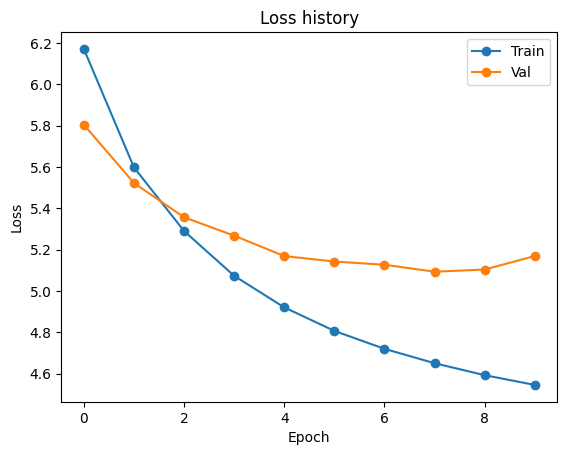

In [62]:
plt.plot(train_history["loss_train"], "o-")
plt.plot(train_history["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

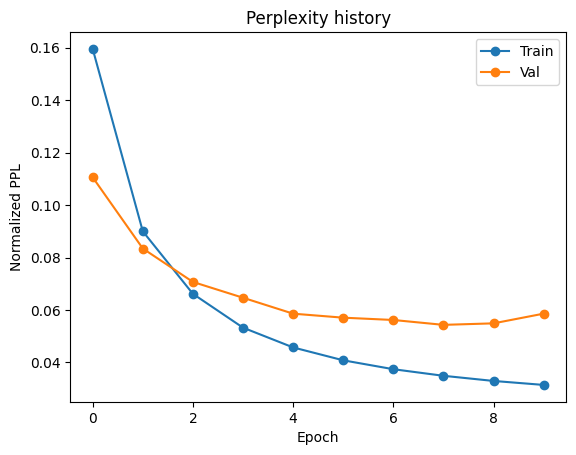

In [63]:
plt.plot(train_history["ppl_train"]/vocab_size, "o-")
plt.plot(train_history["ppl_val"]/vocab_size, "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Normalized PPL")
plt.title("Perplexity history")

plt.show()

## Implementação do LoRA

In [72]:
class LoRA_Module(torch.nn.Module, abc.ABC):

    def __init__(self, original_module:torch.nn.Module, rank:int) -> None:
        super().__init__()

        for param in original_module.parameters():
            param.requires_grad = False

        self._original_module = original_module
        self._rank = rank

    @abc.abstractmethod
    def reduce_module(self) -> torch.nn.Module:
        ...

In [94]:
from torch.nn.modules import Module


class LoRA_Linear(LoRA_Module):
    def __init__(self, linear:torch.nn.Linear, rank:int) -> None:
        super().__init__(linear, rank)
        self._original_module : torch.nn.Linear

        self._in_features = linear.in_features
        self._out_features = linear.out_features

        device = self._original_module.weight.device
        dtype = self._original_module.weight.dtype

        B = torch.empty(self._out_features, rank, device=device, dtype=dtype)
        A = torch.empty(rank, self._in_features, device=device, dtype=dtype)

        self.B = torch.nn.Parameter(B)
        self.A = torch.nn.Parameter(A)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        y1 = self._original_module(x)
        y2 = (x @ self.A.T)@self.B.T

        y = y1+y2
        return y
    
    def reduce_module(self) -> Module:
        
        use_bias = self._original_module.bias is not None
        device = self._original_module.weight.device
        dtype = self._original_module.weight.dtype

        linear = torch.nn.Linear(self._in_features, self._out_features, 
                                 use_bias, device, dtype)
        
        with torch.no_grad():
            W = self._original_module.weight + self.B@self.A

            linear.weight[:] = W
            linear.bias = self._original_module.bias 
        
        return linear



In [112]:
linear = torch.nn.Linear(3,4)
lora_linear = LoRA_Linear(linear, 2)

In [113]:
x = torch.rand(3)

In [114]:
linear(x)

tensor([-0.1892, -0.3406, -0.6479, -0.3250])

In [115]:
lora_linear(x)

tensor([-0.1892, -0.3406, -0.6479, -0.3250], grad_fn=<AddBackward0>)

In [99]:
linear_reduced = lora_linear.reduce_module()

In [107]:
assert_array_equal(linear_reduced(x).detach(), lora_linear(x).detach())

In [103]:
type(linear_reduced) == torch.nn.Linear

True

- [ ] Inicializar pesos da camada
- [ ] Fazer testes direito